In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as pyplot
import imutils

import tensorflow as tf
import keras
from keras import backend as K

Using TensorFlow backend.


In [2]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [3]:
model = keras.models.load_model('bill-segmentation-model-0.9797.h5', custom_objects={'mean_iou': mean_iou})

InternalError: failed initializing StreamExecutor for CUDA device ordinal 0: Internal: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 8335327232

In [ ]:
img = cv2.resize(cv2.cvtColor(cv2.imread('images/2.jpg'), cv2.COLOR_BGR2RGB), (1280, 960))

In [4]:
mask = model.predict(np.array([img / 255.0]))[0]
mask = mask > 0.5

NameError: name 'model' is not defined

In [5]:
def warp_document(mask, img):
    mask[0:3, :] = 0
    mask[:, 0:3] = 0
    mask[mask.shape[0]-3:mask.shape[0], :] = 0
    mask[:, mask.shape[1]-3:mask.shape[1]] = 0
    mask = np.uint8(mask * 255)

    ###

    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(mask,cv2.MORPH_OPEN,kernel, iterations = 2)
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.01*dist_transform.max(),255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    ###

    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers+1
    markers[unknown==255] = 0

    ###

    markers = cv2.watershed(cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB),markers)
    markers = np.where(markers!=1, 1, 0)
    ret, m2 = cv2.threshold(markers.astype(np.uint8), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    m2[0:3, :] = 0
    m2[:, 0:3] = 0
    m2[m2.shape[0]-3:mask.shape[0], :] = 0
    m2[:, m2.shape[1]-3:mask.shape[1]] = 0

    ###

    contours = cv2.findContours(m2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE) 
    cnts = imutils.grab_contours(contours)
    cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    rect = cv2.minAreaRect(cnt)

    box = cv2.boxPoints(rect)

    w, h = 300, 800
    if rect[2] >= -45:
        dst_pts = np.array([[0, h],   [0, 0], [w, 0], [w, h]], dtype=np.float32)
    else:
        dst_pts = np.array([[w, h], [0, h], [0, 0], [w, 0],], dtype=np.float32)
    M = cv2.getPerspectiveTransform(box, dst_pts)
    return cv2.warpPerspective(img, M, (w, h))

In [207]:
warped_bill = warp_document(mask, img)

In [242]:
def image_smoothening(img):
    ret1, th1 = cv2.threshold(img, cv2.THRESH_BINARY, 255, cv2.THRESH_BINARY)
    ret2, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(th2, (5, 5), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th3

In [245]:
def remove_noise_and_smooth(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    filtered = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 41)
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    #img = image_smoothening(img)
    or_image = cv2.bitwise_or(img, closing)
    return or_image

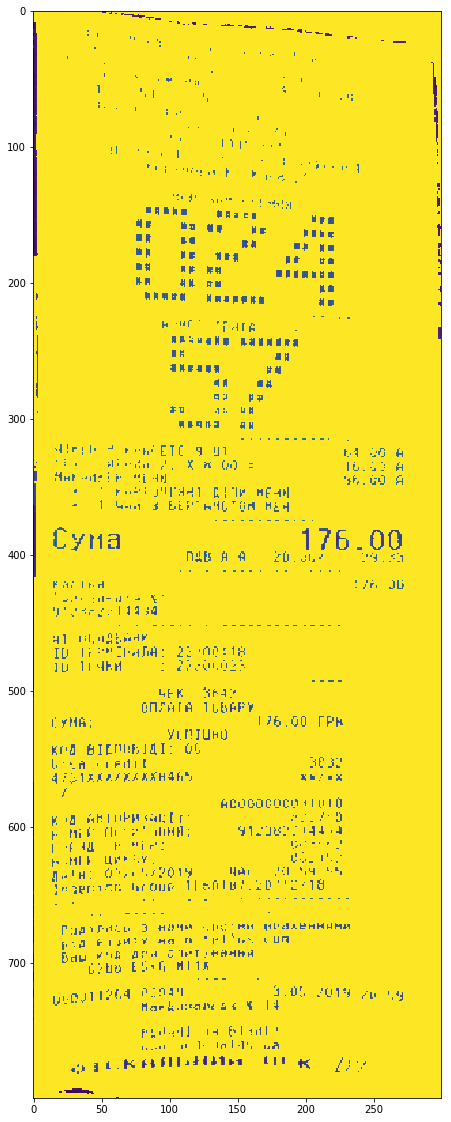

In [246]:
pyplot.figure(figsize=(20, 20))
pyplot.imshow(remove_noise_and_smooth(warped_bill))

In [6]:
denoised = remove_noise_and_smooth(warped_bill)
cv2.imwrite('1_warped.jpg', cv2.cvtColor(warped_bill, cv2.COLOR_BGR2RGB))

NameError: name 'remove_noise_and_smooth' is not defined

In [7]:
import pytesseract

In [8]:
print(pytesseract.image_to_string('text2.png', lang='eng', config='--psm 13 --oem 3'))

64.00


In [9]:
print(pytesseract.image_to_string('text3.png', lang='ukr', config='--psm 13 --oem 3'))

ЧІКЕН МИКНаГЕТС 9 ШТ


In [341]:
print(pytesseract.image_to_string('text4.png', lang='ukr', config='--psm 6 --oem 3'))

ЧІКЕН НИКНАГЕТС 9 ШТ
СОУСОСИРНИЙ 2. Х 8.00 з
Макчикен МЕНЮ
" 1 КАРТОПЛЯНІ ДІПИ МЕНЯ
« | ЦЯй 3 БЕРГАМОТОМ МЕН


In [10]:
print(pytesseract.image_to_string('text4.png', lang='ukr', config='--psm 7 --oem 3'))

In [14]:
print(pytesseract.image_to_string('text4.png', lang='ukr', config='--psm 4 --oem 3'))

ЧІКЕН МИКНАГЕТС 9 о
СОУСОСИРНИЙ 2. Х 8 х
Макчикен МЕНЮ
« 1 КАРТОПЛЯНІ ДІПИ МЕНЯ
« | ЦЯй 3 БЕРГАМОТОМ МЕН
